# Analyzing NYC High School Data

# Read in the data

In [13]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [14]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [15]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [16]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [17]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [18]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [19]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [20]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [21]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [22]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

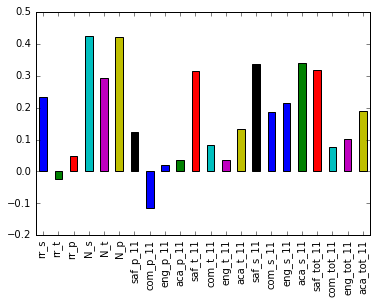

In [23]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards. Very interesting disagreement and may be worth looking into.

## Investigating Safety Scores Further

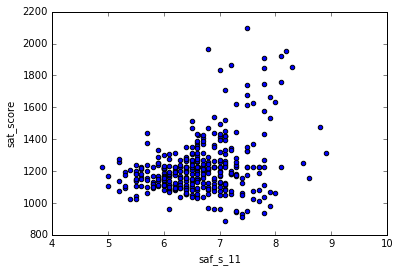

In [24]:
combined.plot.scatter("saf_s_11", "sat_score")

There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

Now we plot this data on a map if NYC, subjectively choosing map extremeties:

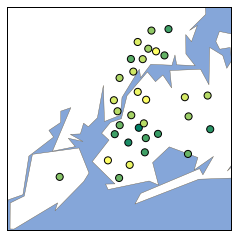

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores. We can see that green indicates low scores whereas yellow indicates higher scores.

## Investigating Racial Differences in Scores Further

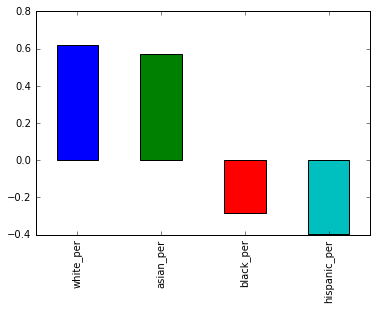

In [26]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

It looks like a higher percentage of white and asian students correlate positively with SAT scores, while a higher percentage of black and hispanic students correlate negatively with SAT scores. This could be due to a lack of funding within schools in areas that have a higher percentage of black and hispanic students, which is relatively known and unsurprising in popular culture.

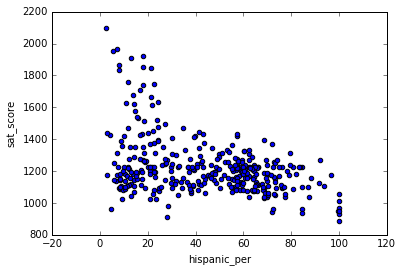

In [27]:
combined.plot.scatter("hispanic_per", "sat_score")

A scatter plot hispanic percentages vs. scores show that there are a few data points where if the hispanic_per is under 20, there are chances for SAT scores to exceed ~1600. Anything past 20%, and SAT scores taper off, which is interesting.

In [28]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above who have a hispanic_per of over 95% appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [29]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Investigating Gender Differences in Scores Further

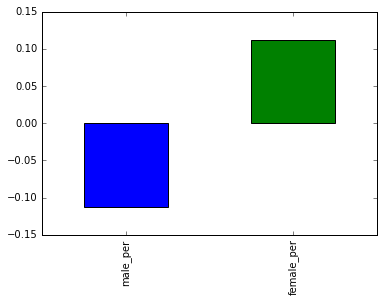

In [30]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

We actually see here that a high percentage of males at a school correlates negatively with scores, whereas a high percentage of females at a school correlates postively with scores, although both of these correlations are pretty close to 0, so may not be worth looking for any causation.

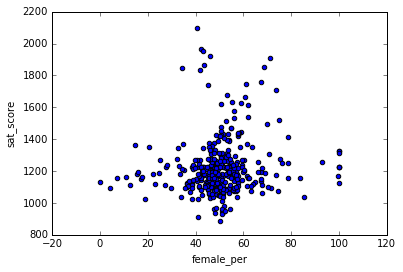

In [31]:
combined.plot.scatter("female_per", "sat_score")

As per the last analysis, this kind of confirms that there isn't any real correlation between female_per and scores. However, we see an interesting cluster between 50-80 female_per where there is a few high score data points.

In [32]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These are school nams with female percent over 60 and scores over 1700. These schools appears to be very selective liberal arts schools that have high academic standards per Google research.

## AP Exam Scores vs SAT Scores

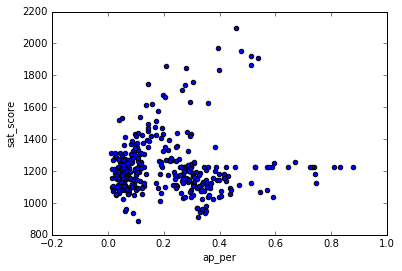

In [33]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter("ap_per", "sat_score")

It looks like there is a small relationship between the percentage of students in a school who take the AP exam, and their average SAT scores, but not anything too significant.

## Futher Analysis
## Class Sizes vs SAT Scores

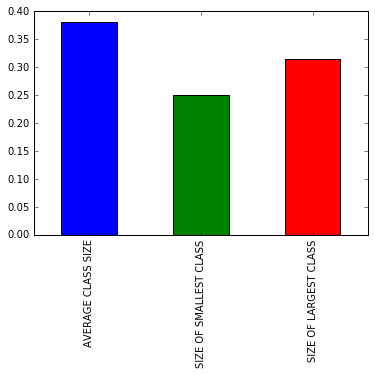

In [34]:
class_sizes = ["AVERAGE CLASS SIZE", "SIZE OF SMALLEST CLASS", "SIZE OF LARGEST CLASS"]
combined.corr()["sat_score"][class_sizes].plot.bar()

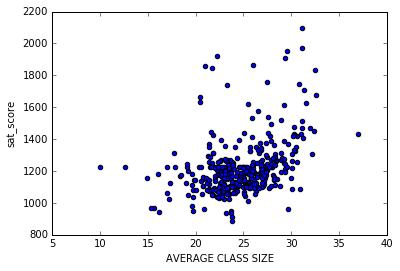

In [35]:
combined.plot.scatter("AVERAGE CLASS SIZE", "sat_score")

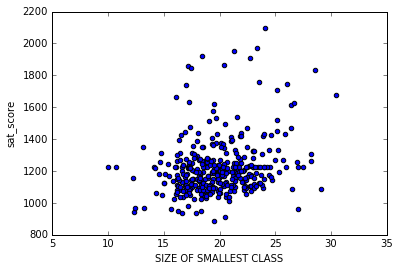

In [36]:
combined.plot.scatter("SIZE OF SMALLEST CLASS", "sat_score")

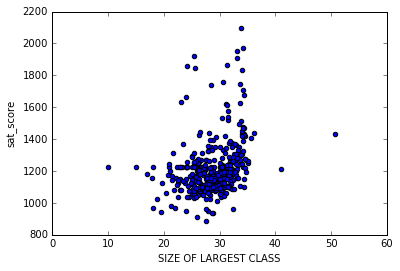

In [37]:
combined.plot.scatter("SIZE OF LARGEST CLASS", "sat_score")

We can see that size of smallest and largest class doesn't tell us as much information as the average class size in general in regards to SAT scores. There is actually a little postivie correlation between class size and scores. This is interesting because you would expect smaller class sizes to have higher scores due to personalization and attention to individual students.

## "Best" School Neighborhoods
We can assume that we can group neighborhoods by school district, since in high school what school you go to is generally determined by proximity. While NYC may be an outlier because there are so many schools to choose from, sticking to this assumption at first makes the analysis simpler, and as it stands there is no way to determine any other grouping of neighborhoods from the data anyways. We would have to get another dataset determining expensive/cheap neighborhoods, property values, etc. to actually get neighborhood distinctions and correlate that with school districts.

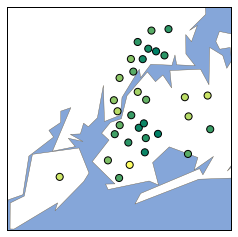

In [38]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["sat_score"], cmap="summer")
plt.show()

It seems that there are two large clusters in Brooklyn and the Bronx where scores are quite lower than average, whereas the average neighborhoods in Manhatten, Queens, and Staten Island (albeit only 1 data point) are higher than these clusters. This makes sense as Brooklyn and the Bronx tend to be viewed as "poorer" areas and this could actually correlate nieghborhood $ values with higher scores. We would expect to confirm this correlation with another dataset.

## Differences Between Parent, Teacher, and Student Responses to Surveys

In [39]:
overall_responses = ["saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
student_responses = ["saf_s_11", "com_s_11", "eng_s_11", "aca_s_11"]
parent_responses = ["saf_p_11", "com_p_11", "eng_p_11", "aca_p_11"]
teacher_responses = ["saf_t_11", "com_t_11", "eng_t_11", "aca_t_11"]

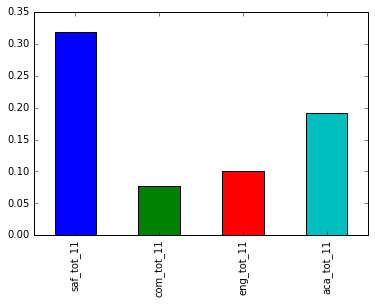

In [40]:
combined.corr()["sat_score"][overall_responses].plot.bar()

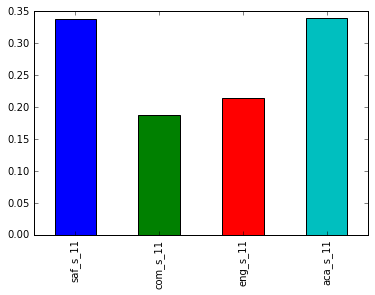

In [41]:
combined.corr()["sat_score"][student_responses].plot.bar()

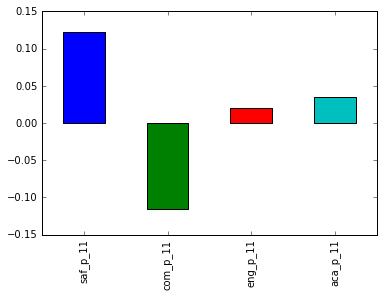

In [42]:
combined.corr()["sat_score"][parent_responses].plot.bar()

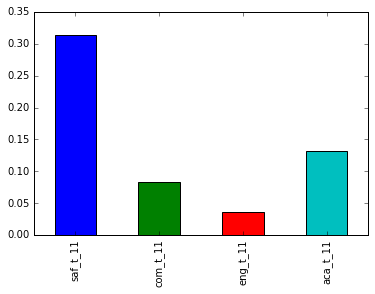

In [43]:
combined.corr()["sat_score"][teacher_responses].plot.bar()

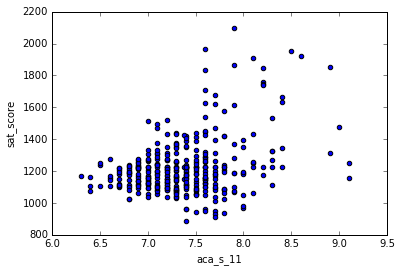

In [44]:
combined.plot.scatter("aca_s_11", "sat_score")

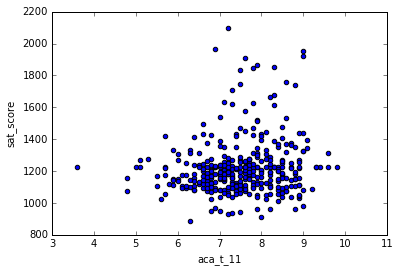

In [45]:
combined.plot.scatter("aca_t_11", "sat_score")

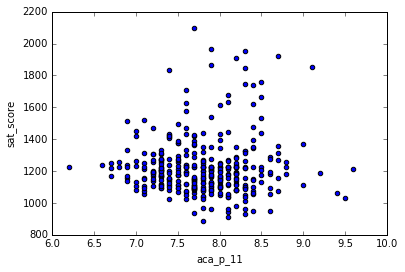

In [46]:
combined.plot.scatter("aca_p_11", "sat_score")

A few takeaways from these differences:
* It looks like the least correlated group to scores out of parents, students, and teachers is parents. This makes sense as they are the least involved in getting the scores (they're not taking the test and also not the ones doing the teaching).
* It seems like the highest correlation across groups to scores is safety and respect scores. This also makes sense as a consensus of good safety and respect for all students, parents, and teachers will probably lead to good learning and good scores.
* The main thing that was unexpected is the difference between academic expectations for students (good positive correlation to scores) vs. academic expectations for parents and teachers (no correlation). Using the scatter plots and inference, this seems to be due to the fact that worse students are self-aware of the academic expectations upon the school and themselves, and will thus mark a lower expectation and get lower scores. Teachers and parents in general seem to hold their children and jobs on higher pedastools than actual, and will thus always seem to think that their class or their child is above average, recording higher expectations. This will then lead to a lesser correlation to actual scores, which shows in the plots.

## Assigning Scores to Schools Based on Attributes
After all of this, let's create a weighted system to rank the schools! Based on all of the data analyzed so far, we can create an arbitrary rankings system. Let's use the attribute of sat_score, ap_per, saf_tot_11, aca_tot_11, and AVERAGE CLASS SIZE. We can choose other categories and fine tune/back test the results for each one, but for now these will do. The weights should add up to 1. Reasonings:
* **sat_score: .35**. This should hold the highest weighting at over a third because it's what we've been basing our analysis on and a good overall predictor of how good a school is in my opinion. 
* **ap_per: .25**. AP percent is also a good prediction indicator, and we weight this a little less at .25.
* **saf_tot_11: .15**. We choose the safety scores and the academic expectations scores to be in this weighting because those two were the most correlated with success in our analysis.
* **aca_tot_11: .1**. Academic expectation scores had a little less prediction value than safety, so while it is included in the weighting it will be weighted a little less.
* **AVERAGE CLASS SIZE: .15**. Average class size also showed a good positive correlation to a school's success based on the analysis, so we include it in the weightings with a .15 weight.

Note that we could've included other factors that had a positive predictor to success such as ethnic percantages, gender percentages, neighborhood correlations, etc. but at that point it just becomes a moral and ethic debate as to whether these categories should be included in projections at all, so we exclude them for the time being.

## Normalize the Values

In [47]:
weighted_set = combined[["SCHOOL NAME", "sat_score", "ap_per", "saf_tot_11", "aca_tot_11", "AVERAGE CLASS SIZE"]]
weighted_set.describe(include = "all")

,SCHOOL NAME,sat_score,ap_per,saf_tot_11,aca_tot_11,AVERAGE CLASS SIZE
count,363,363.000000,363.000000,363.000000,363.000000,363.000000
unique,362,NaN,NaN,NaN,NaN,NaN
top,YOUNG WOMEN'S LEADERSHIP SCHOOL,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN
mean,NaN,1223.438806,0.210503,7.311570,7.569421,24.794077
std,NaN,178.223775,0.167423,0.631169,0.517139,3.555077
min,NaN,887.000000,0.011765,4.900000,5.600000,10.000000
25%,NaN,1113.000000,0.069868,6.900000,7.250000,22.642708
50%,NaN,1193.000000,0.172805,7.300000,7.600000,24.966667
75%,NaN,1266.500000,0.307213,7.700000,7.900000,27.157222


Everything needs to be "normalized" to 100, so we divide SAT scores by 24 (max 2400), multiply the surveys by 10 (max 10), multiply APs by 100 (max 1), and we say the class sizes have a value between 10 and 40, so we multiply the result by 2.5 to get the max to 100. Then the values can be multipled by their respective weights.

In [48]:
weighted_set = weighted_set[weighted_set.notnull()].copy()
weighted_set["sat_score"] = weighted_set["sat_score"] / 24
weighted_set["ap_per"] = weighted_set["ap_per"] * 100
weighted_set["saf_tot_11"] = weighted_set["saf_tot_11"] * 10
weighted_set["aca_tot_11"] = weighted_set["aca_tot_11"] * 10
weighted_set["AVERAGE CLASS SIZE"] = weighted_set["AVERAGE CLASS SIZE"] * 2.5
weighted_set.describe()

,sat_score,ap_per,saf_tot_11,aca_tot_11,AVERAGE CLASS SIZE
count,363.000000,363.000000,363.000000,363.000000,363.000000
mean,50.976617,21.050295,73.115702,75.694215,61.985193
std,7.425991,16.742322,6.311688,5.171388,8.887693
min,36.958333,1.176471,49.000000,56.000000,25.000000
25%,46.375000,6.986750,69.000000,72.500000,56.606771
50%,49.708333,17.280453,73.000000,76.000000,62.416667
75%,52.770833,30.721328,77.000000,79.000000,67.893056
max,87.333333,87.774725,93.000000,91.000000,92.557692


In [49]:
weighted_set = weighted_set[weighted_set.notnull()].copy()
weighted_set["sat_score"] = weighted_set["sat_score"] * .35
weighted_set["ap_per"] = weighted_set["ap_per"] * .25
weighted_set["saf_tot_11"] = weighted_set["saf_tot_11"] * .15
weighted_set["aca_tot_11"] = weighted_set["aca_tot_11"] * .10
weighted_set["AVERAGE CLASS SIZE"] = weighted_set["AVERAGE CLASS SIZE"] * .15
weighted_set["school_score"] = weighted_set["sat_score"] + weighted_set["ap_per"] + weighted_set["saf_tot_11"] + weighted_set["aca_tot_11"] + weighted_set["AVERAGE CLASS SIZE"]
weighted_set.describe()

,sat_score,ap_per,saf_tot_11,aca_tot_11,AVERAGE CLASS SIZE,school_score
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,17.841816,5.262574,10.967355,7.569421,9.297779,50.938945
std,2.599097,4.185580,0.946753,0.517139,1.333154,5.676010
min,12.935417,0.294118,7.350000,5.600000,3.750000,41.259014
25%,16.231250,1.746688,10.350000,7.250000,8.491016,46.651439
50%,17.397917,4.320113,10.950000,7.600000,9.362500,50.303381
75%,18.469792,7.680332,11.550000,7.900000,10.183958,53.316411
max,30.566667,21.943681,13.950000,9.100000,13.883654,73.033360


In [50]:
school_scores = weighted_set[["SCHOOL NAME", "school_score"]].sort_values(by = "school_score").reset_index(drop = True)
print(school_scores)

                                           SCHOOL NAME  school_score
0       FREDERICK DOUGLASS ACADEMY II SECONDARY SCHOOL     41.259014
1    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...     42.023220
2                            MULTICULTURAL HIGH SCHOOL     42.172901
3                            AUGUST MARTIN HIGH SCHOOL     42.311613
4    URBAN ASSEMBLY ACADEMY OF GOVERNMENT AND LAW, THE     42.494872
5                         MARTIN VAN BUREN HIGH SCHOOL     42.606219
6    ACADEMY FOR SOCIAL ACTION: A COLLEGE BOARD SCHOOL     42.624038
7    DR. SUSAN S. MCKINNEY SECONDARY SCHOOL OF THE ...     42.863274
8                           BOYS AND GIRLS HIGH SCHOOL     42.877633
9                                NEW WORLD HIGH SCHOOL     42.923352
10                       BRONX HIGH SCHOOL OF BUSINESS     43.008928
11     HOLCOMBE L. RUCKER SCHOOL OF COMMUNITY RESEARCH     43.192923
12   WORLD ACADEMY FOR TOTAL COMMUNITY HEALTH HIGH ...     43.224191
13   FORDHAM LEADERSHIP ACADEMY FO

Obviously, these score ranges can be improved as they only range from around 40-75. Fitting all schools between 0-100 should provide a better view of how good a school is. This may be the fault of the catgories picked for weights also, as if one weight is negatively correlated with another, it is almost impossible to achieve a score of 100. For now, this is just a basic example of how we can achieve score ratings for each school, and if we wanted to test this further we can backtest this with actual school/city benchmarks, etc. with different weight categories and distributions.